<a href="https://colab.research.google.com/github/xiaobo-fu/python_for_finance/blob/master/fxcmpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [376]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "/content/gdrive/My Drive/G/ML/python_for_finance/source/"
CHAPTER_ID = "python_for_finance"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import cufflinks as cf
from pylab import plt
np.random.seed(1000)
plt.style.use('seaborn')
%matplotlib inline

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [0]:
pip install fxcmpy

In [0]:
import fxcmpy
token = open('/content/gdrive/My Drive/G/ML/python_for_finance/token.txt').read() 
con = fxcmpy.fxcmpy(access_token=token, log_level='error')

In [381]:
print(con.get_instruments())

['EUR/USD', 'USD/JPY', 'GBP/USD', 'USD/CHF', 'EUR/CHF', 'AUD/USD', 'USD/CAD', 'NZD/USD', 'EUR/GBP', 'EUR/JPY', 'GBP/JPY', 'CHF/JPY', 'GBP/CHF', 'EUR/AUD', 'EUR/CAD', 'AUD/CAD', 'AUD/JPY', 'CAD/JPY', 'NZD/JPY', 'GBP/CAD', 'GBP/NZD', 'GBP/AUD', 'AUD/NZD', 'USD/SEK', 'EUR/SEK', 'EUR/NOK', 'USD/NOK', 'USD/MXN', 'AUD/CHF', 'EUR/NZD', 'USD/ZAR', 'USD/HKD', 'ZAR/JPY', 'USD/TRY', 'EUR/TRY', 'NZD/CHF', 'CAD/CHF', 'NZD/CAD', 'TRY/JPY', 'USD/CNH', 'AUS200', 'ESP35', 'FRA40', 'GER30', 'HKG33', 'JPN225', 'NAS100', 'SPX500', 'UK100', 'US30', 'Copper', 'CHN50', 'EUSTX50', 'USDOLLAR', 'US2000', 'USOil', 'UKOil', 'SOYF', 'NGAS', 'WHEATF', 'CORNF', 'Bund', 'XAU/USD', 'XAG/USD', 'EMBasket', 'JPYBasket', 'BTC/USD', 'BCH/USD', 'ETH/USD', 'LTC/USD', 'XRP/USD']


In [382]:
data = con.get_candles('EUR/USD', period='m1', number=250)
data.tail(2)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
date,,,,,,,,,
2019-05-22 17:59:00,1.11607,1.11604,1.11611,1.11602,1.11613,1.11618,1.11623,1.11609,164
2019-05-22 18:00:00,1.11605,1.11596,1.11607,1.11568,1.11618,1.11602,1.11620,1.11574,361


In [383]:
con.is_connected()

True

In [384]:
con.get_account_ids()

[717255]

In [0]:
con.subscribe_market_data('EUR/USD')

In [386]:
con.get_subscribed_symbols()

['EUR/USD']

In [387]:
con.is_subscribed('EUR/USD')

True

In [388]:
con.get_prices('EUR/USD').head()

,Bid,Ask,High,Low
2019-05-22 18:01:17.945,1.11592,1.11597,1.11806,1.11484


In [389]:
con.get_last_price('EUR/USD')

Bid     1.11592
Ask     1.11597
High    1.11806
Low     1.11484
Name: 2019-05-22 18:01:17.945000, dtype: float64

In [390]:
con.get_max_prices()

10000

In [0]:
con.set_max_prices(100000)

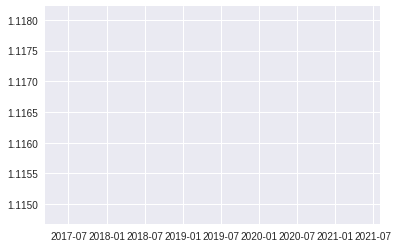

In [392]:
plt.plot(con.get_prices('EUR/USD'))

In [0]:
data = con.get_candles('EUR/USD', period='m5', number=10000)

In [0]:
def datappr(data,lags):
    data['returns'] = np.log(data['bidclose'] / data['bidclose'].shift(1))
    data.dropna(inplace=True)
    global cols
    cols = []
    
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
    
    data.dropna(inplace=True)

    data[cols] = np.where(data[cols] > 0, 1, -1)

    data['direction'] = np.where(data['returns'] > 0, 1, -1)

    mu = data['returns'].mean()
    v = data['returns'].std()
    bins = [mu - v, mu, mu + v]
    
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [0]:
datappr(data,82)

In [0]:
train, test = train_test_split(data, test_size=0.5, shuffle=False, random_state=42)
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)
model.fit(train[cols_bin], train['direction'])
test['position'] = model.predict(test[cols])

In [0]:
test['confidence'] = model.predict_proba(test[cols]).T[1]

In [510]:
model.predict_proba(test[cols])

array([[2.63788991e-13, 1.00000000e+00],
       [3.57149506e-01, 6.42850494e-01],
       [2.22044605e-16, 1.00000000e+00],
       ...,
       [6.91403032e-02, 9.30859697e-01],
       [1.22194292e-07, 9.99999878e-01],
       [3.76509934e-11, 1.00000000e+00]])

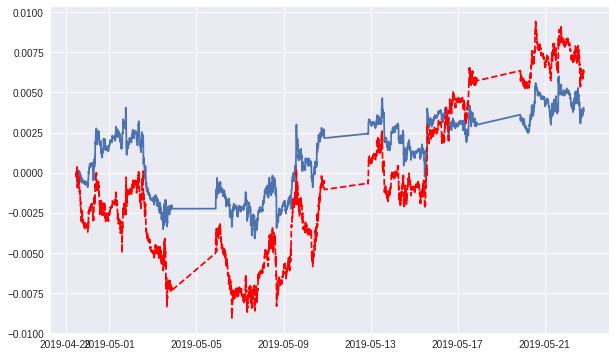

In [517]:
test['strategy'] = test['position'] * test['returns'] * (test['confidence'])
fig = plt.figure(figsize =(10,6))
plt.plot(test['strategy'].cumsum())
test['strategy'] = test['position'] * test['returns']
plt.plot(test['strategy'].cumsum(), '--r')

In [0]:
x = np.arange(10)
np.save('/content/gdrive/My Drive/G/ML/python_for_finance/x.npy', x)